In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Current date
today = datetime.today().strftime("%m/%d/%Y")
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Target accounts
news_org_twitter_names = ['@BBC','@CBS','@CNN','@FoxNews','@nytimes']
color_names = ['lightskyblue','darkgreen','firebrick','mediumblue','gold']
news_org_names = ['BBC','CBS','CNN','Fox','New York Times']
colors = dict(zip(news_org_names, color_names))

In [3]:
# Create a function for the sentiment analysis of each news org
def get_sentiments(target_user):
    # Variables for holding sentiments
    sentiments = []

    # Counter
    counter = 1

    # Variable for max_id
    oldest_tweet = None
    
    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, max_id = oldest_tweet)

        # Loop through all tweets 
        for tweet in public_tweets:

            # Print Tweets
            # print("Tweet %s: %s" % (counter, tweet["text"]))

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            tweets_ago = counter

            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            media_source = target_user[1:]
            if target_user == '@FoxNews': media_source = 'Fox'
            if target_user == '@nytimes': media_source = 'New York Times'
                
            sentiments.append({"Media Sources":media_source,
                               "Compound": compound,
                               "Tweets Ago": counter})

            # Add to counter 
            counter += 1
    return sentiments

In [4]:
sentiments = list()
for target in news_org_twitter_names:
    sentiments += get_sentiments(target)

In [5]:
# Convert sentiments to DataFrame# Conve 
sentiments_pd = pd.DataFrame.from_dict(sentiments)

In [6]:
# sentiments_pd.sort_values(by=['Tweets Ago'], inplace=True, ascending=False)
sentiments_pd.head()

,Compound,Media Sources,Tweets Ago
0,0.3818,BBC,1
1,0.0000,BBC,2
2,0.0000,BBC,3
3,0.0516,BBC,4
4,0.4574,BBC,5


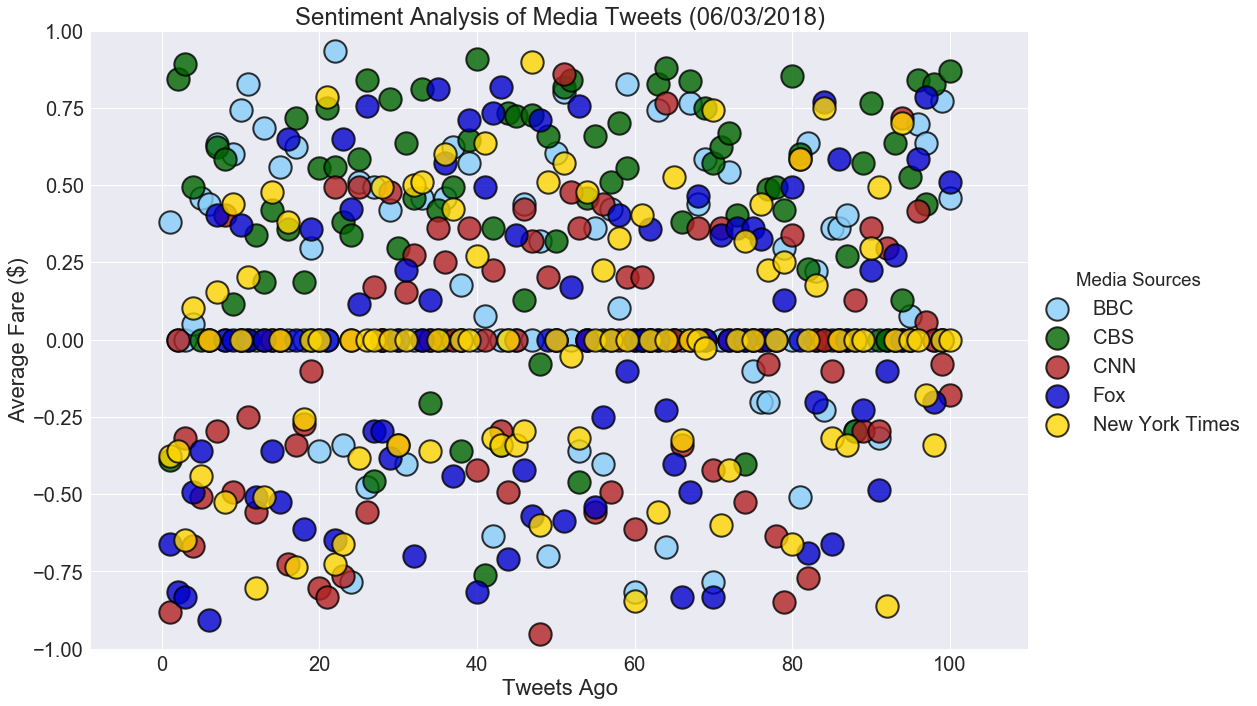

In [7]:
# Plot the sentiments
sns.set_style("darkgrid")
sns.set(font_scale = 2)
# plt.figure(figsize=(50,30))
g = sns.lmplot(x='Tweets Ago',
               y='Compound',
               data=sentiments_pd,
               scatter_kws={'edgecolors':'black',
                            'linewidths':2,
                            'alpha': 0.8,
                            's': 500},             
               hue='Media Sources',
               palette=colors,
               fit_reg=False,
               size=10,
               aspect=1.5,
               legend_out=True)

# set xlim and ylim
g.ax.set_xlim(sentiments_pd['Tweets Ago'].min()-10,sentiments_pd['Tweets Ago'].max()+10)
g.ax.set_ylim(-1,1)
# title, labels
g.ax.set_title(f"Sentiment Analysis of Media Tweets ({today})")
g.ax.set_xlabel("Tweets Ago")
g.ax.set_ylabel("Average Fare ($)")
# g.ax.text(40,37, "Note:\nCircle size correlates with driver count per city.",fontsize=15)
plt.show()

## Second Plot

In [8]:
overall_sentiments_series = sentiments_pd.groupby('Media Sources')['Compound'].mean()

In [29]:
colors = {'BBC': 'lightskyblue',
         'CBS': 'darkgreen',
         'CNN': 'firebrick',
         'Fox': 'mediumblue',
         'NYT': 'gold'}
add_color = lambda org: colors.get(org)

In [30]:
overall_sentiments_pd = overall_sentiments_series.to_frame()
overall_sentiments_pd.reset_index(inplace=True)
# Rename New York Times to NYT
indx=overall_sentiments_pd[overall_sentiments_pd['Media Sources']=='New York Times'].index
overall_sentiments_pd.loc[indx,'Media Sources'] = 'NYT'
# Add colors to the dataframe
overall_sentiments_pd['Colors'] = overall_sentiments_pd['Media Sources'].apply(add_color)

In [31]:
overall_sentiments_pd

,Media Sources,Compound,Colors
0,BBC,0.143025,lightskyblue
1,CBS,0.345564,darkgreen
2,CNN,-0.055766,firebrick
3,Fox,-0.010346,mediumblue
4,NYT,0.000419,gold


In [46]:
# sns.set_style("dark")
# ax = sns.barplot(x=overall_sentiments_pd['Media Sources'],
#                 y=overall_sentiments_pd['Compound'],
#                 palette=overall_sentiments_pd['Colors'],
#                 data= overall_sentiments_pd,
#                 kwargs= {'width':0.1}
#            )
colors = overall_sentiments_pd['Colors'].values
colors

array(['lightskyblue', 'darkgreen', 'firebrick', 'mediumblue', 'gold'],
      dtype=object)

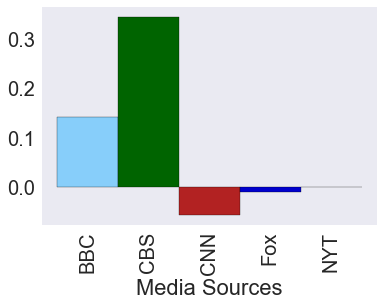

In [50]:
overall_sentiments_pd.plot(kind='bar',
                           x='Media Sources',
                           y='Compound',
                           width=1, 
                           color=colors,
                           legend=False,
                           edgecolor='black')